<a href="https://colab.research.google.com/github/DaeSeokSong/image-processing/blob/feature%2Fimage_segmentation-scar/Image_segmentation_Scar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference

---

## Dataset
* [Wound dataset](https://github.com/uwm-bigdata/wound-segmentation)

---

## Paper
* <**Image Segmentation**> [Automatic Skin Lesion Segmentation Using GrabCut in HSV Colour Space](https://paperswithcode.com/paper/automatic-skin-lesion-segmentation-using-1)

---

# Set development enviroment

## Install

## Import

### Library

In [1]:
# Image processing
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from google.colab.patches import cv2_imshow
from google.colab import output

# ETC
import os
import time

### Google drive mount

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Models/GAN_Scar
!ls -al

/content/gdrive/MyDrive/Models/GAN_Scar
total 20
drwx------ 2 root root  4096 Aug  9 13:27 Dataset
-rw------- 1 root root 16177 Aug 12 15:38 Image_segmentation-Scar.ipynb


# Image segmentation

## Global variable

In [4]:
MODEL_PATH = "/content/gdrive/MyDrive/Models/GAN_Scar"

TRAIN_SET_PATH = "/Dataset/train"
TEST_SET_PATH = "/Dataset/test"

IMAGES_PATH = '/images'
LABELS_PATH = '/labels'

NORM_INPUT_SIZE = 480

## Class

## Function

In [5]:
def imshow_waitkey_enter(image):
    cv2_imshow(image)

    time.sleep(0.5)
    input("Please press the Enter key to proceed\n")
    output.clear()

    pass

## Run

In [6]:
# Set load image dir path
image_path = MODEL_PATH + TRAIN_SET_PATH + IMAGES_PATH
label_path = MODEL_PATH + TRAIN_SET_PATH + LABELS_PATH

# Load train images
os.chdir(image_path)
train_files = os.listdir(image_path)
train_files.sort()

train_images = []
for f in train_files: 
    train_images.append(cv2.imread(f))

# Load label images
os.chdir(label_path)
label_files = os.listdir(label_path)
label_files.sort()

label_images = []
for f in label_files: 
    label_images.append(cv2.imread(f))

Dataset = [(x, label_images[idx]) for idx, x in enumerate(train_images)]

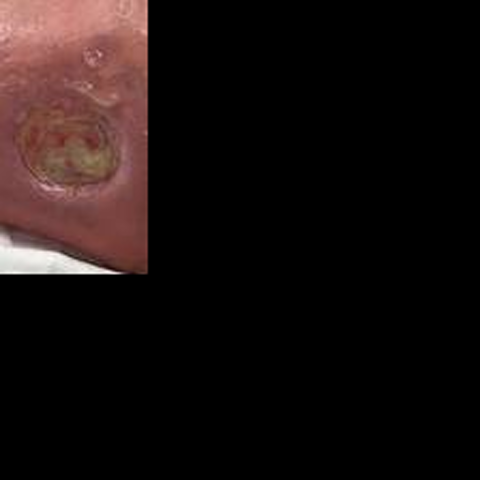

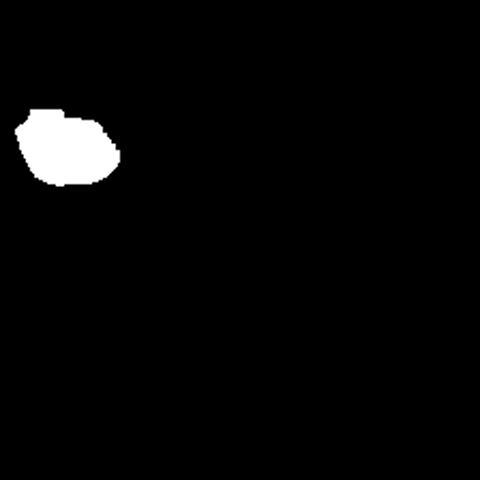

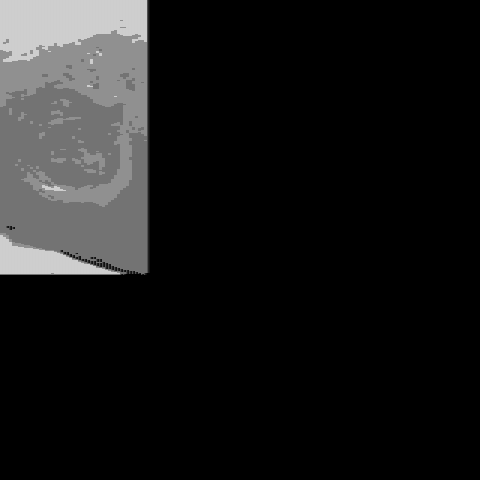

KeyboardInterrupt: ignored

In [14]:
# Preprocess image
for image, label in Dataset:
    # Resize image
    imageW = image.shape[0]
    imageH = image.shape[1]

    resizeRatioW = imageW / NORM_INPUT_SIZE
    resizeRatioH = imageH / NORM_INPUT_SIZE

    image = cv2.resize(image, 
                       (int(imageW / resizeRatioW), int(imageH / resizeRatioH)), 
                       interpolation=cv2.INTER_CUBIC
                       )
    label = cv2.resize(label, 
                       (int(imageW / resizeRatioW), int(imageH / resizeRatioH)), 
                       interpolation=cv2.INTER_CUBIC
                       )

    # Save original image
    origin_image = image.copy()

    # Get HSV image
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue_image, sat_image, val_image = cv2.split(hsv_image)

    # Get grayscale image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold
    _, ths_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)

    # Clustering use K-means
    cluster_data = val_image.reshape((-1, 3)).astype(np.float32)
    
    k = 5
    criteria = (cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0) # 최대 10번 반복하고 1픽셀 이하로 움직이면 종료
    ret, c_label, center = cv2.kmeans(cluster_data, 
                                    k, 
                                    None, 
                                    criteria,
                                    10,
                                    cv2.KMEANS_RANDOM_CENTERS)
    
    center = np.uint8(center)
    dst = center[c_label.flatten()]
    dst = dst.reshape((val_image.shape))

    cv2_imshow(image)
    cv2_imshow(label)
    imshow_waitkey_enter(dst)

In [ ]:
    # Select candidate of wound region
    contours, hierarchy = cv2.findContours(morph_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for idx, contour in enumerate(contours):
        # Substract black boundary
        """
        hierarchy[0][idx], 해당 contour의 계층 정보
        (다음 contour, 이전 contour, 첫번째 자식 contour, 부모 contour)
        """
        if hierarchy[0][idx][0] == -1: continue

        # Delete small region
        x, y, width, height = cv2.boundingRect(contour)
        if width < 20 or height < 20: continue

        box_image = cv2.drawContours(image, contours, idx, (0, 255, 0), -1)
        imshow_waitkey_enter(box_image)

    cv2_imshow(label)
    imshow_waitkey_enter(box_image)